In [1]:
%load_ext autoreload
%autoreload 2

# Get parent directory and add to sys.path
import os
import sys

parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget 

In [2]:
# MPC import
from LinearMPC.MPCVelControl import MPCVelControl
from PIControl.PIControl import PIControl
import numpy as np
from src.rocket import Rocket
from src.vel_rocket_vis import RocketVis

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")

##### Must replace "raise ValueError("State or input constraints violated")" in rocket.py l.423 with 
##### "print(f"State or input constraints violated,\t Alpha = {x0[3]},\t Beta = {x0[4]}")" to run and see the extent of the contraint violation

In [ ]:

Ts = 0.05
sim_time = 20
H = 5.0
x0 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 50, 50, 100])  # initial state
pos_target = np.array([0, 0, 10.0])

rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
pos_controller = PIControl(pos_target)
mpc = MPCVelControl().new_controller(rocket, Ts, H)

t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, ref = rocket.simulate_control(
    mpc, sim_time, H, x0, pos_control=pos_controller, method="nonlinear"
)

In [ ]:
vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 0.5
vis.animate(
    t_cl[:-1],
    x_cl[:, :-1],
    u_cl,
    Ref=ref[:, :-1],
    T_ol=t_ol[..., :-1],
    X_ol=x_ol,
    U_ol=u_ol,
);

In [ ]:
# Print to know how big the constraint violation is
from LinearMPC.utils import ALPHA, BETA

print(f"Max alpha: {np.rad2deg(max(np.abs(x_cl[ALPHA])))}")
print(f"Max beta: {np.rad2deg(max(np.abs(x_cl[BETA])))}")



In [ ]:
from LinearMPC.utils import plot_trajectory
plot_trajectory(t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, mpc.mpc_x)
plot_trajectory(t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, mpc.mpc_y)
plot_trajectory(t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, mpc.mpc_z)
plot_trajectory(t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, mpc.mpc_roll)


#### ============================================ For 5.1 ==============================================

In [3]:
Ts = 0.05
sim_time = 15
H = 5.0
x0 = np.array([0, 0, 0, 0, 0, 0, 5, 5, 10, 0, 0, 1])  # initial state
x_target = np.zeros((12,))

rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
mpc = MPCVelControl().new_controller(rocket, Ts, H)

# Static mass change and zero fuel rate
rocket.mass = 1.5
rocket.fuel_rate = 0.0
t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, ref = rocket.simulate_control(
    mpc, sim_time, H, x0, x_target=x_target, method="nonlinear"
)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Computing maximum invariant set ...
Maximum invariant set successfully computed after 37 iterations.
Computing maximum invariant set ...
Maximum invariant set successfully computed after 37 iterations.
Computing maximum invariant set ...
Maximum invariant set successfully computed after 1 iterations.
Computing maximum invariant set ...
Maximum invariant set successfully computed after 24 iterations.


/Users/jverbois/Python/epfl/MPC-Course-EPFL/.venv/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(


State or input constraints violated,	 Alpha = 10.00680247290367,	 Beta = -9.960884236271362
State or input constraints violated,	 Alpha = 10.028938383223476,	 Beta = -10.0195679816816
State or input constraints violated,	 Alpha = 10.002909758888949,	 Beta = -10.019825436486299
State or input constraints violated,	 Alpha = 10.00202377259227,	 Beta = -9.998163921293097
State or input constraints violated,	 Alpha = 10.00224731753264,	 Beta = -10.001648717997117
State or input constraints violated,	 Alpha = 9.999603452350788,	 Beta = -10.00109088437698


In [4]:
vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 0.5
vis.animate(
    t_cl[:-1],
    x_cl[:, :-1],
    u_cl,
    Ref=ref[:, :-1],
    T_ol=t_ol[..., :-1],
    X_ol=x_ol,
    U_ol=u_ol,
);

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=299), IntSlider(value=0, max=29…

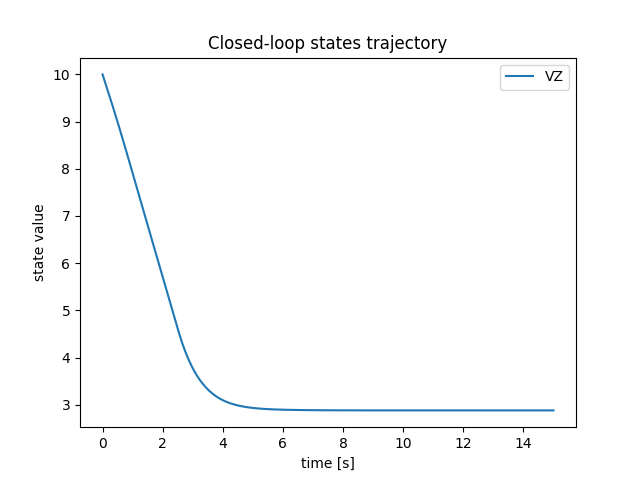

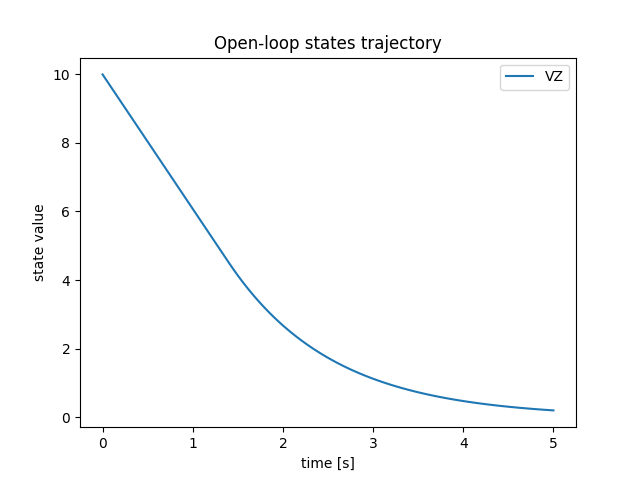

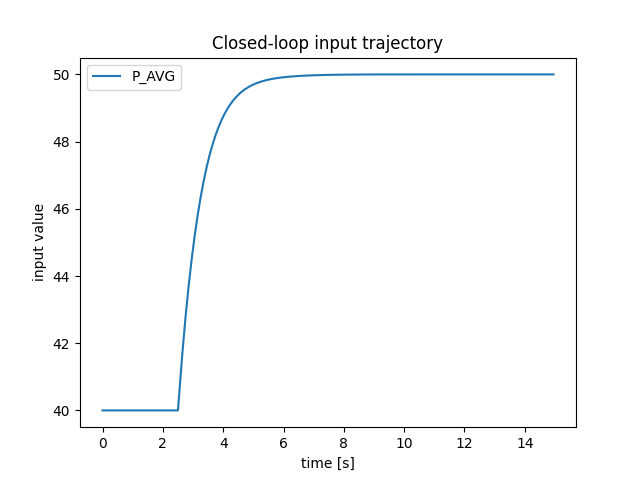

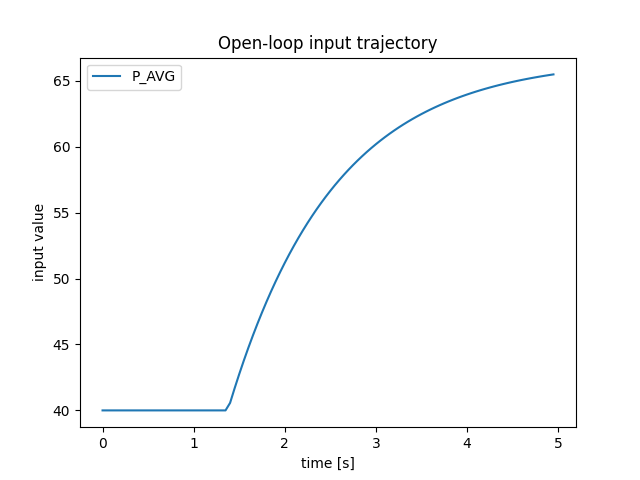

In [5]:
from LinearMPC.utils import plot_trajectory
plot_trajectory(t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, mpc.mpc_z)